### Importando modulos

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np 
import joblib 
import spacy
import os 
import re

from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


from sklearn.metrics import classification_report , confusion_matrix , ConfusionMatrixDisplay

# Filtrar warnings 
import warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2025-09-26 23:02:59.158625: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 23:02:59.169397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-26 23:02:59.186387: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-26 23:02:59.186424: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-26 23:02:59.197792: I tensorflow/core/platform/cpu_feature_gua

### Carregando dados

In [2]:
df_train = pd.read_csv("twitter_training.csv",sep=",")
df_val = pd.read_csv("twitter_validation.csv",sep=",")

In [3]:
df_train.info() , df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column                                                                                                                                                                                                                                     

(None, None)

In [4]:
df_train = df_train.drop(columns=["2401","Borderlands"])
df_val = df_val.drop(columns=['3364','Facebook'])
df_train.rename(
    columns={
        'Positive': 'label',
        'im getting on borderlands and i will murder you all ,' : 'text'
    }, 
    inplace=True
)
df_val.rename(
    columns={
        'Irrelevant': 'label',
        'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣' : 'text'
    }, 
    inplace=True
)

In [5]:
df_val['label'].value_counts() , df_train['label'].value_counts()

(label
 Neutral       285
 Positive      277
 Negative      266
 Irrelevant    171
 Name: count, dtype: int64,
 label
 Negative      22542
 Positive      20831
 Neutral       18318
 Irrelevant    12990
 Name: count, dtype: int64)

In [6]:
df_train, df_test = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train['label'])
print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")


Train: 67212, Validation: 999, Test: 7469


### Pré-processar dados

In [7]:
#!python -m spacy download en_core_web_md -q

In [8]:
nlp = spacy.load('en_core_web_md')
def processing_text(text: str) -> str:
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if token.text.strip()]
    
    return ' '.join(tokens)

In [9]:
df_train['text_processed'] = df_train['text'].astype(str).apply(processing_text)
df_val['text_processed'] = df_val['text'].astype(str).apply(processing_text)
df_test['text_processed'] = df_test['text'].astype(str).apply(processing_text)

In [10]:
df_train.head()

,label,text,text_processed
37007,Neutral,Check out this great career opportunity! Princ...,check out this great career opportunity ! prin...
60274,Negative,<unk> Facebook losing the love battle? flip.it...,< unk > facebook lose the love battle ? flip.i...
63,Neutral,.. [,.. [
23391,Positive,Dear Joining my Google Doodles in thanking pac...,dear join my google doodles in thank packaging...
26236,Positive,think last time ive been truly happy was as th...,think last time i ve be truly happy be as the ...


In [11]:
max_words = 10000  
max_len = 100   

In [12]:
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['text_processed'])

X_train_seq = tokenizer.texts_to_sequences(df_train['text_processed'])
X_val_seq = tokenizer.texts_to_sequences(df_val['text_processed'])
X_test_seq = tokenizer.texts_to_sequences(df_test['text_processed'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [13]:
le = LabelEncoder()
y_train_le=le.fit_transform(df_train['label'])
y_val_le=le.transform(df_val['label'])
y_test_le=le.transform(df_test['label'])
y_train_enc = to_categorical(y_train_le)
y_val_enc = to_categorical(y_val_le)
y_test_enc = to_categorical(y_test_le)

## Construindo modelo

In [14]:
vocab_size = max_words
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2025-09-26 23:10:02.033856: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-26 23:10:02.092515: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 48s 42ms/step - accuracy: 0.6294 - loss: 0.9148 - val_accuracy: 0.8388 - val_loss: 0.4586
Epoch 2/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.7938 - loss: 0.5471 - val_accuracy: 0.8959 - val_loss: 0.3327
Epoch 3/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.8425 - loss: 0.4125 - val_accuracy: 0.9259 - val_loss: 0.2476
Epoch 4/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.8699 - loss: 0.3403 - val_accuracy: 0.9339 - val_loss: 0.2306
Epoch 5/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 51s 48ms/step - accuracy: 0.8884 - loss: 0.2910 - val_accuracy: 0.9389 - val_loss: 0.2310
Epoch 6/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 61s 58ms/step - accuracy: 0.9010 - loss: 0.2565 - val_accuracy: 0.9429 - val_loss: 0.2097
Epoch 7/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 61s 58ms/step - accuracy: 0.9103 - loss: 0.2303 - val_accuracy: 0.9550 - val_loss: 0.1852
Epoch 8/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 64s 61ms/step - accuracy: 0.9189 -

### Avaliando

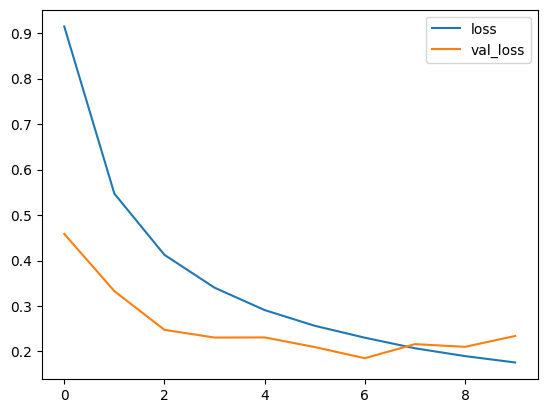

In [16]:
loss , val_loss = history.history['loss'] , history.history['val_loss'] 
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.show()

In [17]:
pred = model.predict(X_test_pad)
pred_labels = np.argmax(pred, axis=1)

234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


In [19]:
y_test_labels = np.argmax(y_test_enc, axis=1)
print(classification_report(y_test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1299
           1       0.86      0.87      0.86      2255
           2       0.82      0.86      0.84      1832
           3       0.85      0.84      0.84      2083

    accuracy                           0.84      7469
   macro avg       0.84      0.84      0.84      7469
weighted avg       0.84      0.84      0.84      7469



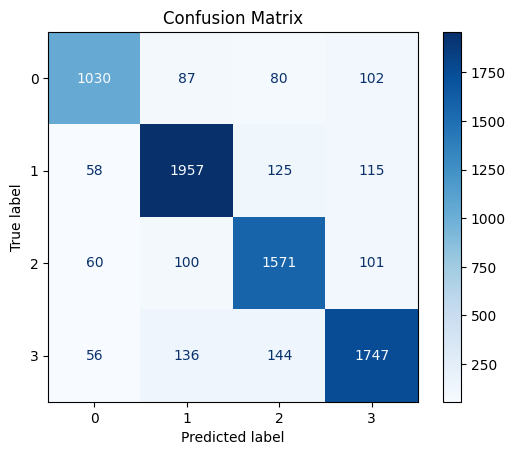

In [20]:
cm = confusion_matrix(y_test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [21]:
joblib.dump(tokenizer, "tokenizer.joblib")
model.save("best_model.h5")